#Setup Tools and Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, log_loss
from sklearn.cross_validation import train_test_split
from sklearn import cluster
from sklearn.decomposition import PCA
from scipy.stats import itemfreq
from mpl_toolkits.mplot3d import Axes3D


pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
%matplotlib inline

In [2]:
!pwd

/home/ec2-user/datakind


In [3]:
%%time
df = pd.read_csv('../data/datakind/data.csv', parse_dates=['reg_date', 'transaction_date'], na_values = 'undefined')

CPU times: user 7.83 s, sys: 548 ms, total: 8.38 s
Wall time: 53.9 s


#Cluster Organizations by Past Purchases

####shape past data into n_orgs X m_items

In [4]:
%%time 
df_cluster = df[df.transaction_date < '2014-01-01 00:00:00.000'][['org', 'item']].set_index('org')
df_cluster = pd.get_dummies(df_cluster.item)
df_cluster = df_cluster.groupby(df_cluster.index).sum()

CPU times: user 54.8 s, sys: 31.6 s, total: 1min 26s
Wall time: 1min 26s


####PCA

In [5]:
%%time
rows = random.sample(df_cluster.index, int(0.1*len(df_cluster.index)))
df_cluster10 = df_cluster.ix[rows]

CPU times: user 1.29 s, sys: 256 ms, total: 1.55 s
Wall time: 1.54 s


In [6]:
X_cluster = df_cluster.values
X_cluster10 = df_cluster10.values
print X_cluster.shape
print X_cluster10.shape

(220938, 4186)
(22093, 4186)


In [7]:
%%time
pca = PCA(n_components = 100)
pca.fit(X_cluster10)

CPU times: user 5min 7s, sys: 1.19 s, total: 5min 8s
Wall time: 5min 9s


In [8]:
X_cluster_pca = pca.transform(X_cluster)

#####feed PCA transformation into K Means

In [9]:
%%time
km = cluster.KMeans(init='k-means++', n_clusters=20, random_state=2, max_iter = 1000)
km.fit(X_cluster_pca)

km_labels = km.labels_

CPU times: user 2min 37s, sys: 704 ms, total: 2min 38s
Wall time: 2min 38s


####clusters from the first 3 PCs

In [10]:
x = X_cluster_pca[:,0]
y = X_cluster_pca[:,1]
z = X_cluster_pca[:,2]

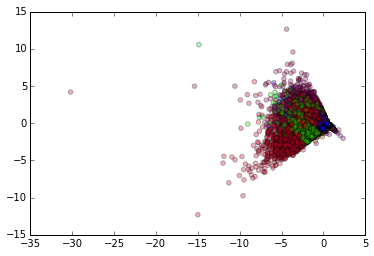

In [11]:
plt.scatter(x,y, c=km_labels, cmap=plt.cm.brg, alpha = .3)

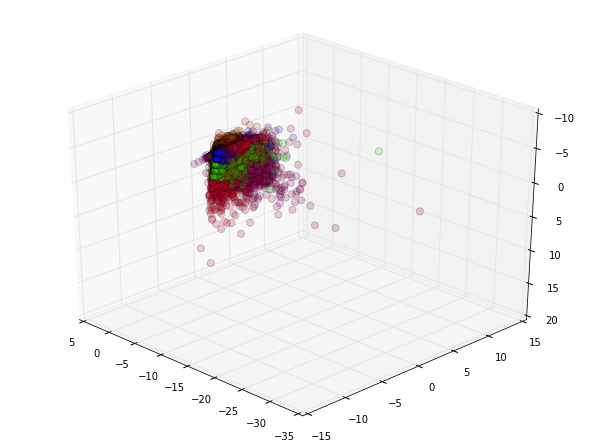

In [12]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=45)
ax.scatter(x, y, z, c= km_labels,
           cmap=plt.cm.brg, alpha = .2, s = 50)

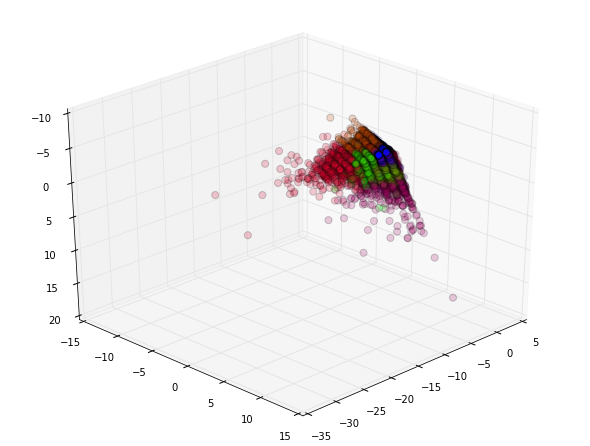

In [13]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=-45)
ax.scatter(x, y, z, c= km_labels,
           cmap=plt.cm.brg, alpha = .2, s = 50)

In [14]:
df_org_cluster = pd.DataFrame(zip(df_cluster.index,km_labels),columns = ['org','org_cluster']).set_index('org')


#Prepare Data for Recommender System

In [15]:
df_model = df[df.transaction_date >= '2014-01-01 00:00:00.000']

In [16]:
idx_max_tran = df_model.reset_index().groupby('org')[['index','transaction_date']].max()['index'].tolist()

In [17]:
df_model = df_model.ix[idx_max_tran][['org','org_type', 'org_subtype', 'budget',
                                      'reg_date', 'role', 'country']].set_index('org')

#####transform reg_date into a timedelta

In [18]:
df_model['years_since_base'] = df_model.reg_date.map(lambda x: (x - np.datetime64('2000-01-01 00:00:00.000'))/datetime.timedelta(days=1))

In [19]:
df_model = df_model.drop('reg_date',axis=1)

#####shape  y into n_orgs X m_items

In [20]:
%%time
df_items = df[df.transaction_date >= '2014-01-01 00:00:00.000']
df_items = df_items[['org','item']].set_index('org')
df_items = pd.get_dummies(df_items.item)
df_items = df_items.groupby(df_items.index).sum()

CPU times: user 7.88 s, sys: 4.77 s, total: 12.6 s
Wall time: 12.6 s


####drop rare purchased items from y

In [21]:
%%time
df_items_sum = df_items.sum()
cols = df_items_sum[df_items_sum>=100].index

CPU times: user 12.3 s, sys: 1.16 s, total: 13.5 s
Wall time: 13.5 s


In [22]:
df_y = df_items.ix[df_model.index,cols]

In [23]:
df_X = df_model.join([df_org_cluster])

In [24]:
print df_X.shape
print df_y.shape


(141419, 7)
(141419, 352)


######more transformations
- assign customers with no previous purhcase history to a cluster

- impute nulls and 'bad' columns

- label encode categorical variables


In [25]:
df_X.loc[df_X.org_cluster.isnull(), 'org_cluster'] = 20
df_X.loc[df_X.role.isnull(), 'role'] = 0
df_X.loc[(df_X.budget < 0)|(df_X.budget.isnull()), 'budget'] = 0


In [26]:
for i in ['org_subtype','country']:
    label_encoder = preprocessing.LabelEncoder()
    df_X[i] = label_encoder.fit_transform(df_X[i])

In [27]:
for i in df_y.columns:
    df_y.loc[df_y[i]>0,i]=1

In [28]:
X = df_X.values
y = df_y.values

#Recommender System using Random Forest 

In [29]:
#keep records of everything 
rf_log_loss_scores = {}
rf_y_predicted_probas = {}
rf_estimators = {}
rf_clfs = {}
rf_feature_importances = {}
X_tests = {}
y_tests = {}


In [30]:
%%time
for i in range(len(y[1])):
        y_iter = y[:,i]

        X_train, X_test, y_train, y_test = train_test_split(X, y_iter, test_size = 0.25, random_state=99)
        
        clf = RandomForestClassifier(n_jobs = -1, n_estimators=500)
        clf.fit(X_train, y_train)

        y_predicted_proba = clf.predict_proba(X_test)
        log_loss_score = log_loss(y_test, y_predicted_proba)
        
        rf_y_predicted_probas[i] = y_predicted_proba
        rf_log_loss_scores[i] = log_loss_score
        rf_clfs[i] = clf
        rf_estimators[i] = clf.estimators_
        rf_feature_importances[i] = clf.feature_importances_
        X_tests[i] = X_test
        y_tests[i] = y_test

CPU times: user 5h 39min 38s, sys: 14min 42s, total: 5h 54min 21s
Wall time: 17min 39s


In [33]:
import pickle

with open('rf_log_loss_scores.p', 'wb') as handle:
    pickle.dump(rf_log_loss_scores, handle)

with open('rf_y_predicted_probas.p', 'wb') as handle:
    pickle.dump(rf_y_predicted_probas, handle)
    
with open('rf_feature_importances.p', 'wb') as handle:
    pickle.dump(rf_feature_importances, handle)
    
with open('X_tests.p', 'wb') as handle:
    pickle.dump(X_tests, handle)

with open('y_tests.p', 'wb') as handle:
    pickle.dump(y_tests, handle)
    

In [ ]:
with open('rf_estimators.p', 'wb') as handle:
    pickle.dump(rf_estimators, handle)

with open('rf_clfs.p', 'wb') as handle:
    pickle.dump(rf_clfs, handle)


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure(figsize = (10,10))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

In [ ]:
plot_roc_curve(y_tests[10], rf_y_predicted_probas[10])